<a href="https://colab.research.google.com/github/leinaxd/NOTES/blob/main/digital_image_processing/notebooks/11b_polygon_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

source

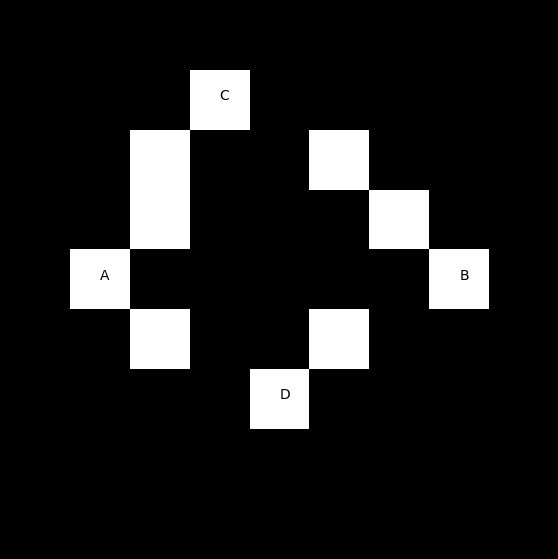

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

img = np.array(
    [[0,0,0,0,0,0,0,0,0],
     [0,0,0,1,0,0,0,0,0],
     [0,0,1,0,0,1,0,0,0],
     [0,0,1,0,0,0,1,0,0],
     [0,1,0,0,0,0,0,1,0],
     [0,0,1,0,0,1,0,0,0],
     [0,0,0,0,1,0,0,0,0],
     [0,0,0,0,0,0,0,0,0],
     [0,0,0,0,0,0,0,0,0]])
plt.figure(figsize=(7,7))
plt.imshow(img, cmap='gray')
plt.text(1,4,'A',color='k')
plt.text(7,4,'B',color='k')
plt.text(3,1,'C',color='k')
plt.text(4,6,'D',color='k')
plt.axis('off');

Ramer–Douglas–Peucker algorithm (Polygon fitting)
- Usefull for finding polygons like triangles, rectangles in the picture
- for example in vision, you can frame entities as a pre-processor
- Also usefull for tracing a river

[4 1] [4 7] 5 [4 1] 0.0


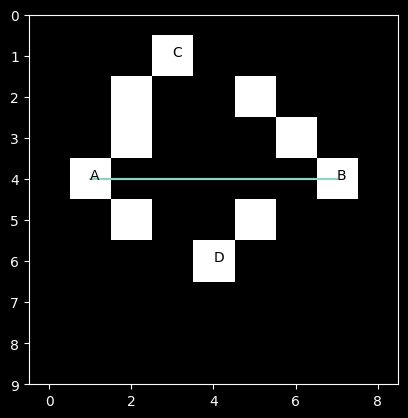

In [246]:
def polygon_fitting(img, T, closed=True):
    """A: starting point, B Ending point, T:threshold
    Note: If the curve is open, A,B are the natural endpoints
          if the curve is closed, A,B are the leftmost & rightmost points
          - Require an ordered list of points (ie. after boundary following algorithm)
    """
    # Collect the points of the image
    points = []
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            if img[r,c]==1: points.append((r,c))
    points = np.array(points)

    #find the leftmost & rightmost points (col dimension)
    A, B = 0, 0
    for ix, p in enumerate(points):
        if p[1]<points[A][1]: A = ix
        if p[1]>points[B][1]: B = ix
    
    #Define 2 stacks
    final = [B]
    if closed:  in_process = [B,A] 
    else:       in_process = [A]

    #iterate
    while len(in_process) > 0:
        A = points[in_process[-1]]
        B = points[final[-1]]

        d_max = 0
        next_point = None
        # for i in range(len(points)):
        for i in range(in_process[-1], final[-1]):
            p = points[i]

            d = np.linalg.norm(np.cross(B - A, p - A)) / np.linalg.norm(B - A)
            print(A,B, i, p, d)
            if d > d_max:
                d_max = d
                next_point = i
        # print(points[next_point])
        if d_max >=T:
            print('D>T')
            in_process.append(next_point)
        else:
            p = in_process.pop()
            final.append(p)


    return np.array([points[p] for p in final])

simplified_points = polygon_fitting(img, T=0.5)
lines = simplified_points
plt.imshow(img, cmap='gray')
plt.plot(lines.T[1], lines.T[0])
plt.ylim([img.shape[1],0])
plt.text(1,4,'A',color='k')
plt.text(7,4,'B',color='k')
plt.text(3,1,'C',color='k')
plt.text(4,6,'D',color='k');

In [ ]:
import numpy as np

def boundary_points(img):
    # Collect the points of the image
    # ordered from leftmost to rightmost (col dimension)
    points = []
    for c in range(img.shape[1]):
        for r in range(img.shape[0]):
            if img[r,c]==1: points.append((r,c))     
    #sort by proximity in a counterclockwise manner
    sorted_points = []
    sorted_points.append(points.pop(0))
    while len(points) > 0:
        n = np.array(points)
        dn = n-np.array(sorted_points[-1])
        norm_dn = np.abs(dn).sum(1)
        ix = norm_dn.argmin()
        sorted_points.append(points.pop(ix))
    return np.array(sorted_points)

def polygon_fitting(points, T):
    stack = [(0, len(points) - 1)]     
    simplified_points = [points[0]]
    while len(stack) > 0:
        start, end = stack.pop()  
        d_max = 0
        index = 0
        A = points[start] #start point
        B = points[end]   #end point

        #iterate those points between start and end
        for i in range(start+1, end):
            p = points[i] #current_point
            d = np.abs(np.cross(B - A, p - A))/np.linalg.norm(B-A)
            if d > d_max:
                d_max = d
                index = i
        if d_max > T:
            stack.append((start, index))  # Add the left subcurve indices to the stack
            stack.append((index, end))  # Add the right subcurve indices to the stack
        else:
            simplified_points.append(points[start])  # Add the start point to the simplified curve
            simplified_points.append(points[end])  # Add the end point to the simplified curve

    return np.array(simplified_points)

points = boundary_points(img)
plt.plot(points[:,1], points[:,0])
plt.figure()
s_points = polygon_fitting(points, T=1)
plt.imshow(img, cmap='gray')
plt.plot(s_points[:,1], s_points[:,0])
plt.text(1,4,'A',color='k')
plt.text(7,4,'B',color='k')
plt.text(3,1,'C',color='k')
plt.text(4,6,'D',color='k');

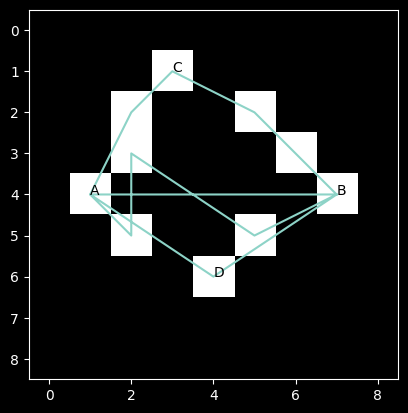

In [252]:

import numpy as np
import matplotlib.pyplot as plt

def polygon_fitting(img, T, closed=True):
    """A: starting point, B: ending point, T: threshold
    Note: If the curve is open, A, B are the natural endpoints
          if the curve is closed, A, B are the leftmost & rightmost points
    """
    P = []
    for c in range(img.shape[1]):
        for r in range(img.shape[0]):
            if img[r, c] == 1:
                P.append((r, c))
    A = P[0]
    B = P[-1]

    final = [B]
    if closed:
        in_process = [B, A]  # note if closed
    else:
        in_process = [A]

   
    while len(in_process) != 0:
        A = final[-1]
        B = in_process[-1]

        max_dist = 0
        next_point = None
        for p in P:
            # Is the point between A and B?
            p = np.array(p)
            A = np.array(A)
            B = np.array(B)
            projection = np.dot(p - A, B - A) / (np.linalg.norm(B - A) ** 2+1E-10)
            if projection < 0 or projection > 1: continue
            
            min_dist = np.linalg.norm(p - projection * (B - A))
            if min_dist > max_dist:
                max_dist = min_dist
                next_point = p

        if max_dist >= T:
            in_process.append(next_point)
            P = [point for point in P if not np.array_equal(point, next_point)]
        else:
            p = in_process.pop()
            final.append(p)

    return np.array(final)

# Example usage
s_points = polygon_fitting(img, T=2)
plt.imshow(img, cmap='gray')
plt.plot(s_points[:,1], s_points[:,0])
plt.text(1,4,'A',color='k')
plt.text(7,4,'B',color='k')
plt.text(3,1,'C',color='k')
plt.text(4,6,'D',color='k');